In [4]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
from IPython import display
import time


# Environment Setup

In [5]:
# Frequency Control Porblem Environment
class Frequency(gym.Env):
    def  __init__(self, Pm,M,D,F,G,delta_t,max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.M=M
        self.D=D
        self.Pm=Pm
        self.G=G
        self.max_action=max_action
        self.dim_action=dim_action
        self.omega_scale=2*np.pi
        self.viewer = None
        self.state=[]
        self.delta_t=delta_t
        self.Penalty_action=Penalty_action
#         self.state_transfer1=np.vstack((np.hstack((np.identity(dim_action,dtype=np.float32),\
#                                                    np.zeros((dim_action,dim_action),dtype=np.float32))),\
#                                 np.hstack((delta_t*np.identity(dim_action,dtype=np.float32),\
#                                            -delta_t*np.diag(M**(-1))@np.diag(D)@np.identity(dim_action,dtype=np.float32)))))
        self.state_transfer1=np.vstack((np.hstack((np.identity(dim_action,dtype=np.float32),\
                                                   np.zeros((dim_action,dim_action),dtype=np.float32))),\
                                np.hstack((delta_t*self.omega_scale*np.identity(dim_action,dtype=np.float32),\
                                           np.identity(dim_action,dtype=np.float32)))))
        self.state_transferF=-delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*F
        self.state_transferG=-delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*G

    
        self.state_transfer2=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))        

        self.state_transfer3=np.hstack((np.zeros((1,dim_action),dtype=np.float32),\
                                        delta_t*Pm*(M**(-1))))
        self.state_transfer4=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        -delta_t*np.diag((M**(-1)))))

        self.select_add_w=np.vstack((np.zeros((dim_action,1),dtype=np.float32),\
                                        np.ones((dim_action,1),dtype=np.float32)))
        self.select_w=np.vstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))
        self.select_delta=np.vstack((np.identity(dim_action,dtype=np.float32),\
                                        np.zeros((dim_action,dim_action),dtype=np.float32)))
        
        ### continuous version
#         self.state_transfer1_continuous=np.vstack((np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),np.zeros((dim_action,dim_action),dtype=np.float32))),\
#                             np.hstack((np.identity(dim_action,dtype=np.float32),-np.diag(M**(-1))@np.diag(D)))))
        
        self.state_transfer1_continuous=np.vstack((np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),np.zeros((dim_action,dim_action),dtype=np.float32))),\
                                np.hstack((self.omega_scale*np.identity(dim_action,dtype=np.float32),np.zeros((dim_action,dim_action),dtype=np.float32)))))
        self.state_transferF_continuous=-(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*F
        self.state_transferG_continuous=-(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*G
        self.state_transfer3_continuous=np.hstack((np.zeros((1,dim_action),dtype=np.float32),\
                                        Pm*(M**(-1))))
        self.state_transfer4_continuous=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        -np.diag((M**(-1)))))
        self.minus_ref_one=np.vstack((np.hstack((-np.ones((1,dim_action-1)),np.zeros((1,dim_action-1)))),\
                                    np.hstack((np.identity(dim_action-1),np.zeros((dim_action-1,dim_action-1)))),\
                                    np.hstack((np.zeros((1,dim_action-1)),-np.ones((1,dim_action-1)))),\
                                    np.hstack((np.zeros((dim_action-1,dim_action-1)),np.identity((dim_action-1))))))
        self.minus_ref_one_recover_u=np.vstack((np.zeros((dim_action-1,dim_action)),\
                                                np.hstack((np.ones((dim_action-1,1)),-np.identity(dim_action-1)))))
                                                
    
    
    
        

    def step(self, action):
        self.state=copy.deepcopy(self.state@self.state_transfer1\
                     + np.sum(np.sin( np.transpose(self.state@self.select_delta)@np.ones((1,dim_action),dtype=np.float32)-\
                        np.ones((dim_action,1),dtype=np.float32)@(self.state@self.select_delta))*self.state_transferF
                        +(np.cos( np.transpose(self.state@self.select_delta)@np.ones((1,dim_action),dtype=np.float32)-\
                         np.ones((dim_action,1),dtype=np.float32)@(self.state@self.select_delta))\
                          -np.identity(dim_action,dtype=np.float32))*self.state_transferG\
                              ,axis=1 )@self.state_transfer2\
                     + self.state_transfer3\
                                 +action@self.state_transfer4)

            
        loss = self.param_gamma*pow(self.state,2)@self.select_add_w 
        return self.state, loss
    
    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        initial_state1=np.random.uniform(0.0,0.3,(1,self.dim_action))
        initial_state2=np.random.uniform(-0.03,0.03,(1,self.dim_action))
        s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)
        self.state = s_concate

        return self.state
    


    


In [6]:
# Simulation data load from IEEE 39-bus system

data = loadmat('IEEE_39bus_Kron.mat')
K_EN=data['Kron_39bus']['K']
K_EN=np.asarray(K_EN, dtype=np.float32)

H=data['Kron_39bus']['H']
H=np.asarray(H, dtype=np.float32)

Damp=data['Kron_39bus']['D']
Damp=np.asarray(Damp, dtype=np.float32)

omega_R=data['Kron_39bus']['omega_R']
gamma=data['Kron_39bus']['gamma']
gamma=np.asarray(gamma, dtype=np.float32)

A_EN=data['Kron_39bus']['A']
A_EN=np.asarray(A_EN, dtype=np.float32)



In [7]:
dim_action=10 #dimension of action space
dim_state=2*dim_action #dimension of state space
delta_t=0.02
# M=H.reshape(dim_action)*2/omega_R
M=H.reshape(dim_action)*2/omega_R*2*np.pi
D=Damp.reshape(dim_action)/omega_R*2*np.pi
F=K_EN*np.cos(gamma)
G=-K_EN*np.sin(gamma)*1.
Pm=A_EN.reshape((1, -1))
Penalty_action=0.005
max_action=np.array([[1.1643361, 5.072242 , 4.765774 , 4.142611 , 4.124881 , 4.7717752,
        4.528778 , 4.201154 , 6.0463214, 1.4594682]],dtype=np.float32)
env = Frequency(Pm,M,D,F,G,delta_t,max_action,dim_action,Penalty_action)


In [8]:
def Action_linear(state,linear_coff,env):
    action_nonconstrain=(state@env.select_w)*linear_coff
    action=env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action


linear_coff0=loadmat('Sol_lossy_std_0221.mat')

linear_coff=linear_coff0['Sol']
linear_coff=np.asarray(linear_coff, dtype=np.float32).reshape(1,-1)

[[3.721005]]


Text(0, 0.5, 'w (p.u.)')

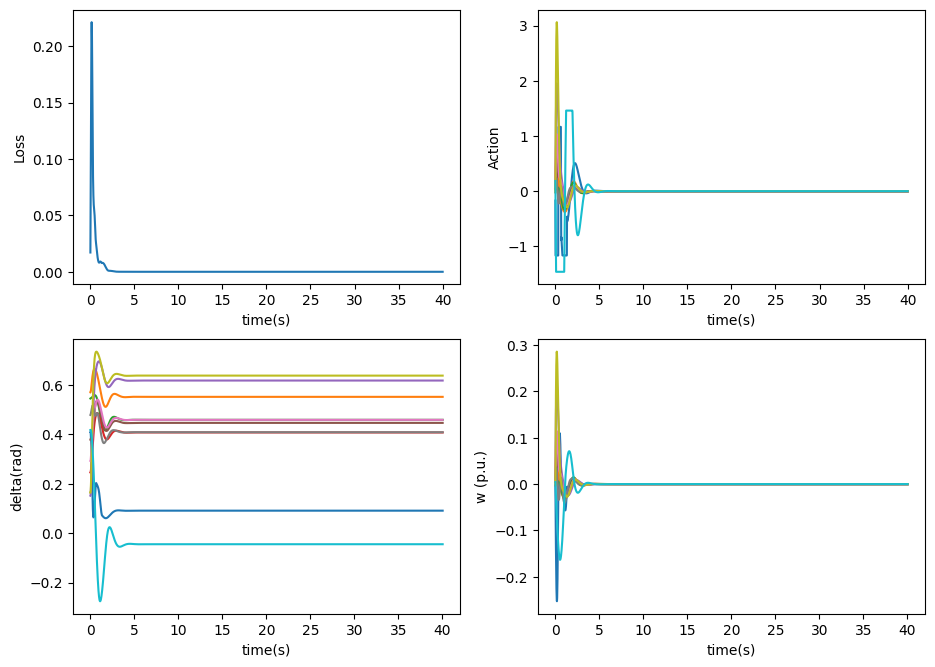

In [9]:
# Compare the trajectory
action_units=dim_action
Trajectory_RNN=[] 

init_state=np.array([[  0.40964973,  0.5706315 ,  0.5454999 ,  0.24582419,  0.15178671,
         0.37899652,  0.2926271 ,  0.47890443,  0.16405383,  0.41809   ,
        -0.00210736,  0.00391182,  0.00452287,  0.00385107,  0.01104757,
        -0.00272085,  0.00774046,  0.01003703, -0.0014925 ,  0.00431693]],dtype=np.float32)
# initial_state1=np.random.uniform(-0.1,0.1,(1,dim_action))*5
# initial_state2=np.random.uniform(-0.2,0.2,(1,dim_action))*5.
# s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)
s=init_state
env.set_state(s)
Trajectory_RNN.append(s)
SimulationLength=2000
Record_u=[]
Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
for i in range(SimulationLength):

    u=np.squeeze(Action_linear(s,linear_coff,env))
    next_s, r= env.step(u)
    Loss_RNN_discounted+=r
    Loss_RNN+=r
    s=next_s
    Trajectory_RNN.append(s)
    Record_u.append(u)
    Record_Loss.append(np.squeeze(r))

print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

In [10]:
equilibrium_init=Trajectory_RNN[-1,:].copy()

print(equilibrium_init)
equilibrium_init

[ 9.1133572e-02  5.5222386e-01  4.5910427e-01  4.0786996e-01
  6.1828053e-01  4.4674450e-01  4.5903459e-01  4.0887848e-01
  6.3822925e-01 -4.4816729e-02 -4.2042561e-09  5.7612905e-08
 -6.6400922e-08 -2.2351742e-08  2.3165575e-07 -9.5316047e-08
  2.2351742e-08 -4.7830888e-08  1.1007423e-07 -1.2233481e-08]


array([ 9.1133572e-02,  5.5222386e-01,  4.5910427e-01,  4.0786996e-01,
        6.1828053e-01,  4.4674450e-01,  4.5903459e-01,  4.0887848e-01,
        6.3822925e-01, -4.4816729e-02, -4.2042561e-09,  5.7612905e-08,
       -6.6400922e-08, -2.2351742e-08,  2.3165575e-07, -9.5316047e-08,
        2.2351742e-08, -4.7830888e-08,  1.1007423e-07, -1.2233481e-08],
      dtype=float32)

# Lyapunov Model

In [11]:
class Lyapunov_model(tf.keras.Model):

  def __init__(self,dim_state,Lya_internal_units):
    super(Lyapunov_model, self).__init__()
    self.dense1 = tf.keras.layers.Dense(Lya_internal_units, input_dim=dim_state, activation=tf.nn.elu)
    # self.dense1 = tf.keras.layers.Dense(Lya_internal_units, input_dim=dim_state, activation=tf.nn.sigmoid)

    self.dropout = tf.keras.layers.Dropout(0.01)
#     self.dense2 = tf.keras.layers.Dense(30, input_dim=dim_state, activation=tf.nn.tanh tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1)

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    return self.dense2(x)

In [13]:
# select the bus 1 as the reference bus
class Lyapunov_Train_ref():

    def __init__(self, env, batchsize,action_units,linear_coff,equilibrium,Norm_control):

        self.batchsize=batchsize
        self.action_units=action_units
        self.equilibrium=tf.convert_to_tensor(equilibrium,dtype=tf.float32)
        self.M=tf.constant(env.M,dtype=tf.float32)
        self.G=tf.constant(env.G,dtype=tf.float32)
        self.Pm=tf.constant(env.Pm,dtype=tf.float32)
        self.Norm_control=tf.constant(Norm_control,dtype=tf.float32)
        self.linear_coff=tf.constant(linear_coff.T,dtype=tf.float32)
        self.state_transfer1_continuous=tf.constant(env.state_transfer1_continuous,dtype=tf.float32)
        self.state_transferF_continuous=tf.constant(env.state_transferF_continuous,dtype=tf.float32)
        self.state_transferG_continuous=tf.constant(env.state_transferG_continuous,dtype=tf.float32)
        self.state_transfer2=tf.constant(env.state_transfer2,dtype=tf.float32)
        self.state_transfer3_continuous=tf.constant(env.state_transfer3_continuous,dtype=tf.float32)
        self.state_transfer4_continuous=tf.constant(env.state_transfer4_continuous,dtype=tf.float32)
        self.select_add_w=tf.constant(env.select_add_w,dtype=tf.float32)
        self.select_w=tf.constant(env.select_w,dtype=tf.float32)
        self.select_delta=tf.constant(env.select_delta,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.Multiply_ones=tf.tile(tf.ones((action_units,action_units),dtype=tf.float32)[None], [batchsize, 1, 1]) 
        self.Multiply_ones_diag=tf.tile(tf.eye(action_units,dtype=tf.float32)[None], [batchsize, 1, 1]) 
        self.minus_ref_one=tf.constant(env.minus_ref_one,dtype=tf.float32)

    
    def Sample(self,env, delta_limit,w_limit):
#         initial_state1=tf.random.uniform(shape=[self.batchsize-1,env.dim_action], minval=-delta_limit, maxval=delta_limit,dtype=tf.float32)
#         initial_state2=tf.random.uniform(shape=[self.batchsize-1,env.dim_action], minval=-w_limit, maxval=w_limit,dtype=tf.float32)
        initial_state1=tf.random.truncated_normal(shape=[self.batchsize-1,env.dim_action],  mean=0.0, stddev=delta_limit, dtype=tf.float32)
        initial_state2=tf.random.truncated_normal(shape=[self.batchsize-1,env.dim_action],  mean=0.0, stddev=w_limit, dtype=tf.float32)

        prev_output0=tf.concat([initial_state1, initial_state2], 1)+self.equilibrium
        prev_output=tf.concat([self.equilibrium, prev_output0], 0)
        action_init=K.sum(tf.linalg.diag(K.dot(prev_output,self.select_w))*self.linear_coff,axis=2)
        action=self.max_action-K.relu(self.max_action-action_init)+K.relu(-self.max_action-action_init)



        D_f_t=K.dot(prev_output, self.state_transfer1_continuous)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF_continuous,axis=2 )\
                          +K.sum((K.cos( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))-self.Multiply_ones_diag)\
                        *self.state_transferG_continuous,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3_continuous+K.dot(action,self.state_transfer4_continuous)
         # Minus_ref
        D_f_t_minus_ref=K.dot(D_f_t,self.minus_ref_one)
        prev_output_minus_ref=K.dot(prev_output,self.minus_ref_one)
        

        return [prev_output_minus_ref[1:], D_f_t_minus_ref[1:],prev_output_minus_ref[0:1,:],D_f_t_minus_ref[0:1,:]]
    
    def Sample_active(self,env, delta_limit,w_limit,delta_limit_small, w_limit_small,sample_ratio ):
#         initial_state1=tf.random.uniform(shape=[self.batchsize-1,env.dim_action], minval=-delta_limit, maxval=delta_limit,dtype=tf.float32)
#         initial_state2=tf.random.uniform(shape=[self.batchsize-1,env.dim_action], minval=-w_limit, maxval=w_limit,dtype=tf.float32)
        Num_sample_small=int(np.floor(sample_ratio*(self.batchsize-1)))
        initial_state1=tf.random.truncated_normal(shape=[self.batchsize-1-Num_sample_small,env.dim_action],  mean=0.0, stddev=delta_limit, dtype=tf.float32)
        initial_state2=tf.random.truncated_normal(shape=[self.batchsize-1-Num_sample_small,env.dim_action],  mean=0.0, stddev=w_limit, dtype=tf.float32)
        # initial_state1=tf.random.uniform(shape=[self.batchsize-1-Num_sample_small,env.dim_action], minval=-delta_limit, maxval=delta_limit,dtype=tf.float32)
        # initial_state2=tf.random.uniform(shape=[self.batchsize-1-Num_sample_small,env.dim_action], minval=-w_limit, maxval=w_limit,dtype=tf.float32)

        initial_state1_small=tf.random.truncated_normal(shape=[Num_sample_small,env.dim_action],  mean=0.0, stddev=delta_limit_small, dtype=tf.float32)
        initial_state2_small=tf.random.truncated_normal(shape=[Num_sample_small,env.dim_action],  mean=0.0, stddev=w_limit_small, dtype=tf.float32)
          
        prev_output0=tf.concat([initial_state1, initial_state2], 1)+self.equilibrium
        prev_output0_small=tf.concat([initial_state1_small, initial_state2_small], 1)+self.equilibrium
        prev_output1=tf.concat([prev_output0_small, prev_output0], 0)
        prev_output=tf.concat([self.equilibrium, prev_output1], 0)

        # print('prev_output',prev_output)
        # action=K.sum(tf.linalg.diag(K.dot(prev_output,self.select_w))*self.linear_coff,axis=2)
        action_init=K.sum(tf.linalg.diag(K.dot(prev_output,self.select_w))*self.linear_coff,axis=2)
        action=self.max_action-K.relu(self.max_action-action_init)+K.relu(-self.max_action-action_init)



        D_f_t=K.dot(prev_output, self.state_transfer1_continuous)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF_continuous,axis=2 )\
                          +K.sum((K.cos( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))-self.Multiply_ones_diag)\
                        *self.state_transferG_continuous,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3_continuous+K.dot(action,self.state_transfer4_continuous)
         # Minus_ref
        D_f_t_minus_ref=K.dot(D_f_t,self.minus_ref_one)
        prev_output_minus_ref=K.dot(prev_output,self.minus_ref_one)
        

        return [prev_output_minus_ref[1:], D_f_t_minus_ref[1:],prev_output_minus_ref[0:1,:],D_f_t_minus_ref[0:1,:]]        
    
    def Train (self,Record_ConvergePoint, Dervative_f_time, equilibrium,Dervative_f_time_equilibrium):
        equilibrium=tf.convert_to_tensor(equilibrium,dtype=tf.float32)
#         Dervative_f_time=tf.convert_to_tensor(Dervative_f_time,dtype=tf.float32)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(Record_ConvergePoint)
            tape.watch(equilibrium)
            Lyapunov_value=Lyapunov(Record_ConvergePoint)
            partial_grads=tape.gradient(Lyapunov_value, Record_ConvergePoint)
            Derivative_Lya_time=tf.math.reduce_sum(partial_grads*Dervative_f_time,axis=1)

            Lyapunov_value_equilibrium=Lyapunov(equilibrium)
            partial_grads_equilibrium=tape.gradient(Lyapunov_value_equilibrium, equilibrium)
            Derivative_Lya_time_equilibrium=tf.math.reduce_sum(partial_grads_equilibrium\
                                                               *Dervative_f_time_equilibrium,axis=1)
            ## Costruct Loss function

            Loss=((15*tf.math.reduce_sum(tf.nn.tanh(Derivative_Lya_time)\
                                       *tf.math.exp(-tf.norm(Record_ConvergePoint-equilibrium,axis=1)/self.Norm_control))\
                    +10*tf.math.reduce_sum(tf.nn.relu(-Lyapunov_value+Lyapunov(equilibrium))))/Dervative_f_time.get_shape()[0]\
                    +60*Derivative_Lya_time_equilibrium**2+100*tf.nn.relu(Derivative_Lya_time_equilibrium))/Dervative_f_time.get_shape()[0]
            

            grads = tape.gradient(Loss, Lyapunov.trainable_weights)
            optimizer.apply_gradients(zip(grads, Lyapunov.trainable_weights))

        
    
        return Loss
        

    def Compuate_Dervative_Lya (self,prev_output):
        prev_output=tf.convert_to_tensor(prev_output,dtype=tf.float32)
        action=K.sum(tf.linalg.diag(K.dot(prev_output,self.select_w))*self.linear_coff,axis=2)
        sample_length=np.shape(prev_output)[0]
        self.Multiply_ones_sample=tf.tile(tf.ones((self.action_units,self.action_units),dtype=tf.float32)[None], [sample_length, 1, 1]) 
        self.Multiply_ones_diag_sample=tf.tile(tf.eye(action_units,dtype=tf.float32)[None], [sample_length, 1, 1]) 

        D_f_t=K.dot(prev_output, self.state_transfer1_continuous)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones_sample,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF_continuous,axis=2 )\
                          +K.sum(K.cos( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones_sample,tf.linalg.diag(K.dot(prev_output, self.select_delta)))-self.Multiply_ones_diag_sample)\
                        *self.state_transferG_continuous,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3_continuous+K.dot(action,self.state_transfer4_continuous)
         # Minus_ref
        D_f_t_minus_ref=K.dot(D_f_t,self.minus_ref_one)
        prev_output_minus_ref=K.dot(prev_output,self.minus_ref_one)

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_output_minus_ref)
            Lyapunov_value=Lyapunov(prev_output_minus_ref)
            partial_grads=tape.gradient(Lyapunov_value, prev_output_minus_ref)


        Derivative_Lya_time=tf.math.reduce_sum(partial_grads*D_f_t_minus_ref,axis=1)
  
    
        return [Derivative_Lya_time, Lyapunov_value]      



In [14]:
def Compute_derivative (Record_ConvergePoint, Dervative_f_time, equilibrium,Dervative_f_time_equilibrium):
    equilibrium=tf.convert_to_tensor(equilibrium,dtype=tf.float32)
    Record_ConvergePoint=tf.convert_to_tensor(Record_ConvergePoint,dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(Record_ConvergePoint)
        tape.watch(equilibrium)
        Lyapunov_value=Lyapunov(Record_ConvergePoint)
        partial_grads=tape.gradient(Lyapunov_value, Record_ConvergePoint)
        Derivative_Lya_time=tf.math.reduce_sum(partial_grads*Dervative_f_time,axis=1)
        Lyapunov_value_equilibrium=Lyapunov(equilibrium)
        partial_grads_equilibrium=tape.gradient(Lyapunov_value_equilibrium, equilibrium)
        Derivative_Lya_time_equilibrium=tf.math.reduce_sum(partial_grads_equilibrium*Dervative_f_time_equilibrium,axis=1)
    return Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium

In [ ]:
# Minus_ref
episodes =4000# total number of iterations to update weights
episodes_first=200
episodes_second=2000
action_units_Lya=dim_action
units_Lya=2*action_units #dimension of each state
Hidden_units_Lya=50
Batch_Size_Lya=500
PrintUpdate=100
Ratio_detivative_threshold=0.95

Intial_upper_w_Lya=10
Initial_upper_delta_Lya=2
Norm_control=10
Initial_upper_delta_Lya_small=0.2
Intial_upper_w_Lya_small=0.5
small_ratio=0.5

Loss_record_Lya=[]
tf.keras.backend.set_floatx('float32')
Lyapunov=Lyapunov_model(action_units_Lya-1,Hidden_units_Lya)
global_step = tf.Variable(0, trainable=False)
learning_rate_initial=0.05
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 100, 0.9, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

start = time.time()

TrainData=Lyapunov_Train_ref(env, Batch_Size_Lya,action_units_Lya,linear_coff,equilibrium_init.reshape(1,dim_action*2),Norm_control)
for iter in range(episodes_first):
    [prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=TrainData.Sample(env,Initial_upper_delta_Lya\
                                                                                    ,Intial_upper_w_Lya)
    Loss=TrainData.Train(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
    Loss_record_Lya.append(Loss)
    if iter % (PrintUpdate) == 0:
        print('episode',iter, 'Loss',Loss)
[Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
=Compute_derivative(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
idx_OutBound=tf.squeeze(tf.where(Derivative_Lya_time>0))
      
Value_OutBound=tf.reshape(tf.gather(prev_output,idx_OutBound),((-1,prev_output.shape[1])))

Dot_Value_OutBound=tf.reshape(tf.gather(D_f_t,idx_OutBound),((-1,D_f_t.shape[1])))            
Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/Batch_Size_Lya
for iter in range(episodes_first,episodes_second):
    if Ratio_detivative<Ratio_detivative_threshold:
        [prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=TrainData.Sample(env,Initial_upper_delta_Lya\
                                                                                  ,Intial_upper_w_Lya)
        Loss=TrainData.Train(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
        Loss_record_Lya.append(Loss)
        [Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
            =Compute_derivative(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
        Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/Batch_Size_Lya

        if iter % (PrintUpdate) == 0:
            print('episode',iter, 'Loss',Loss)
            print('episode',iter, 'Ratio_detivative<0',Ratio_detivative)
    if Ratio_detivative>=Ratio_detivative_threshold:

        [prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=TrainData.Sample(env,Initial_upper_delta_Lya\
                                                                                        ,Intial_upper_w_Lya)
        Prev_output_combine=tf.concat([prev_output,Value_OutBound],axis=0)
        D_f_t_combine=tf.concat([D_f_t,Dot_Value_OutBound],axis=0)
        Loss=TrainData.Train(Prev_output_combine, D_f_t_combine,equilibrium_train_calc, D_f_t_equilibrium)
        Loss_record_Lya.append(Loss)
        
        [Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
            =Compute_derivative(Prev_output_combine, D_f_t_combine,equilibrium_train_calc, D_f_t_equilibrium)
        idx_OutBound=tf.squeeze(tf.where(Derivative_Lya_time>0))


        Value_OutBound=tf.reshape(tf.gather(Prev_output_combine,idx_OutBound),((-1,Prev_output_combine.shape[1])))
        Dot_Value_OutBound=tf.reshape(tf.gather(D_f_t_combine,idx_OutBound),((-1,D_f_t_combine.shape[1])))
        Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/D_f_t_combine.get_shape()[0]


        if iter % (PrintUpdate) == 0:
            print('episode',iter, 'Loss after add bad sample',Loss)

for iter in range(episodes_second,episodes):
    if Ratio_detivative<Ratio_detivative_threshold:

        [prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=\
              TrainData.Sample_active(env,Initial_upper_delta_Lya,Intial_upper_w_Lya,\
                                      Initial_upper_delta_Lya_small,Intial_upper_w_Lya_small, small_ratio )
        Loss=TrainData.Train(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
        Loss_record_Lya.append(Loss)
        [Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
            =Compute_derivative(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
        Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/Batch_Size_Lya

        if iter % (PrintUpdate) == 0:
            print('episode',iter, 'Loss',Loss)
    if Ratio_detivative>=Ratio_detivative_threshold:

        [prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=\
              TrainData.Sample_active(env,Initial_upper_delta_Lya,Intial_upper_w_Lya,\
                                      Initial_upper_delta_Lya_small,Intial_upper_w_Lya_small, small_ratio )
        Prev_output_combine=tf.concat([prev_output,Value_OutBound],axis=0)
        D_f_t_combine=tf.concat([D_f_t,Dot_Value_OutBound],axis=0)
        Loss=TrainData.Train(Prev_output_combine, D_f_t_combine,equilibrium_train_calc, D_f_t_equilibrium)
        Loss_record_Lya.append(Loss)
        
        [Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
            =Compute_derivative(Prev_output_combine, D_f_t_combine,equilibrium_train_calc, D_f_t_equilibrium)
        idx_OutBound=tf.squeeze(tf.where(Derivative_Lya_time>0))


        Value_OutBound=tf.reshape(tf.gather(Prev_output_combine,idx_OutBound),((-1,Prev_output_combine.shape[1])))
        Dot_Value_OutBound=tf.reshape(tf.gather(D_f_t_combine,idx_OutBound),((-1,D_f_t_combine.shape[1])))
        Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/D_f_t_combine.get_shape()[0]


        if iter % (PrintUpdate) == 0:
            print('episode',iter, 'Loss after add bad sample',Loss)

end = time.time()
duration=end-start

print('computaion time', duration)







In [ ]:
plt.plot(Loss_record_Lya)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [17]:
def Compute_derivative (Record_ConvergePoint, Dervative_f_time, equilibrium,Dervative_f_time_equilibrium):
    equilibrium=tf.convert_to_tensor(equilibrium,dtype=tf.float32)
    Record_ConvergePoint=tf.convert_to_tensor(Record_ConvergePoint,dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(Record_ConvergePoint)
        tape.watch(equilibrium)
        Lyapunov_value=Lyapunov(Record_ConvergePoint)
        partial_grads=tape.gradient(Lyapunov_value, Record_ConvergePoint)
        Derivative_Lya_time=tf.math.reduce_sum(partial_grads*Dervative_f_time,axis=1)
        Lyapunov_value_equilibrium=Lyapunov(equilibrium)
        partial_grads_equilibrium=tape.gradient(Lyapunov_value_equilibrium, equilibrium)
        Derivative_Lya_time_equilibrium=tf.math.reduce_sum(partial_grads_equilibrium*Dervative_f_time_equilibrium,axis=1)
    return Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium

In [18]:
[Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
=Compute_derivative(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/Batch_Size_Lya
Ratio_Lya=tf.reduce_sum(tf.cast(Lyapunov_value>Lyapunov_value_equilibrium, tf.float32))/Batch_Size_Lya
print('the ratio that V_dot smaller than 0',Ratio_detivative)
print('the ratio that V larger than V at equlibrium',Ratio_Lya)

the ratio that V_dot smaller than 0 tf.Tensor(0.998, shape=(), dtype=float32)
the ratio that V larger than V at equlibrium tf.Tensor(0.998, shape=(), dtype=float32)


# Results in smaller region

In [21]:
test_delta_range=0.2
test_omega_range=0.5
TrainData. batchsize=500
[prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium]=TrainData.Sample(env,test_delta_range\
                                                                                    ,test_omega_range)
[Lyapunov_value,Derivative_Lya_time,Lyapunov_value_equilibrium,Derivative_Lya_time_equilibrium]\
=Compute_derivative(prev_output, D_f_t,equilibrium_train_calc, D_f_t_equilibrium)
Ratio_detivative=tf.reduce_sum(tf.cast(Derivative_Lya_time<=0, tf.float32))/Batch_Size_Lya
Ratio_Lya=tf.reduce_sum(tf.cast(Lyapunov_value>Lyapunov_value_equilibrium, tf.float32))/Batch_Size_Lya
print('the ratio that V_dot smaller than 0',Ratio_detivative)
print('the ratio that V larger than V at equlibrium',Ratio_Lya)

the ratio that V_dot smaller than 0 tf.Tensor(0.998, shape=(), dtype=float32)
the ratio that V larger than V at equlibrium tf.Tensor(0.998, shape=(), dtype=float32)


## plot Lyapunov and Lie Lyapunov

In [22]:
s_concate=tf.make_ndarray(tf.make_tensor_proto(equilibrium_init.reshape((1,-1))))
equilibrium_init=equilibrium_init.reshape((1,-1))
gen_idx=7
state_d=np.arange(-Initial_upper_delta_Lya,Initial_upper_delta_Lya,Initial_upper_delta_Lya/200)+equilibrium_init[0,gen_idx]
state_w=np.arange(-Intial_upper_w_Lya,Intial_upper_w_Lya,Intial_upper_w_Lya/200)+equilibrium_init[0,gen_idx+action_units]

X, Y = np.meshgrid(state_d-equilibrium_init[0,gen_idx], state_w)  
Plot_State_input_record=[]
for i in range(len(state_d)):
    for j in range(len(state_w)):
        s_concate[0,gen_idx]=state_d[i]
        s_concate[0,gen_idx+action_units]=state_w[j]
        Plot_State_input_record.append(s_concate.copy())
Plot_State_input_record=np.squeeze(np.array(Plot_State_input_record))
[Derivative_Lya_time_sample, Lyapunov_value_sample]=TrainData.Compuate_Dervative_Lya (Plot_State_input_record)   

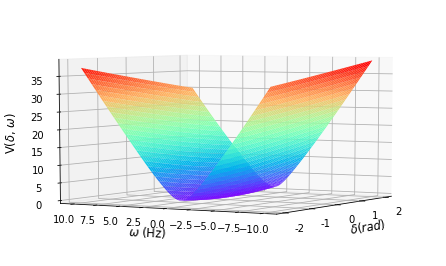

In [23]:
fig = plt.figure(1, figsize=(6, 3.5))

fontsize_new=11.5
ax = Axes3D(fig)
X, Y = np.meshgrid(state_d-equilibrium_init[0,gen_idx], state_w)  
surf=ax.plot_surface(X, Y, tf.transpose(tf.reshape(Lyapunov_value_sample,(len(state_w),-1)))-np.squeeze(Lyapunov(equilibrium_train_calc)), cmap=plt.get_cmap('rainbow'))

ax.set_xlabel('$\delta (rad) $ ',fontsize=fontsize_new)
ax.set_xticks(range(-2,3,1))
ax.set_xticklabels(range(-2,3,1),fontsize=10)

ax.set_ylabel('$\omega$ (Hz)',fontsize=fontsize_new)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation

ax.set_zlabel('V($\delta$, $\omega$) ', rotation=90,fontsize=fontsize_new)
ax.view_init(elev=5, azim=210)



In [24]:
# plt.rcParams['text.usetex'] = True
import matplotlib
matplotlib.rcParams['text.usetex'] =False


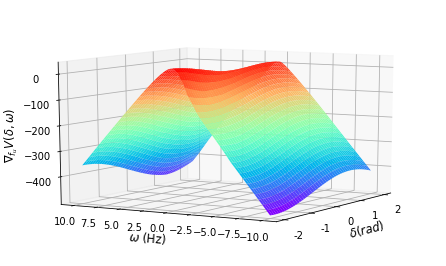

In [25]:
fig = plt.figure(1, figsize=(6, 3.5))
# plt.figure(figsize=(11, 2), dpi=100)

# plt.subplot(1,2,1)
fontsize_new=11.5
ax = Axes3D(fig)

surf=ax.plot_surface(X, Y, tf.transpose(tf.reshape(Derivative_Lya_time_sample,(len(state_w),-1))), cmap=plt.get_cmap('rainbow'))

ax.set_xlabel('$\delta (rad) $ ',fontsize=fontsize_new)
ax.set_xticks(range(-2,3,1))
ax.set_xticklabels(range(-2,3,1),fontsize=10)
ax.set_ylabel('$\omega$ (Hz)',fontsize=fontsize_new)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation

ax.set_zlabel(''r'$\nabla_{f_u} V(\delta, \omega)$', rotation=90,fontsize=fontsize_new)

ax.view_init(elev=10, azim=210)


# RNN for Control

In [26]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,exp_alpha,**kwargs):
        self.units = units
        self.action_units=action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.exp_alpha=exp_alpha#exp_stable_threshold
        self.delta_t=tf.constant(env.delta_t,dtype=tf.float32)
        
        self.state_transfer1=tf.constant(env.state_transfer1,dtype=tf.float32)
        self.state_transferF=tf.constant(env.state_transferF,dtype=tf.float32)
        self.state_transferG=tf.constant(env.state_transferG,dtype=tf.float32)
        self.state_transfer2=tf.constant(env.state_transfer2,dtype=tf.float32)
        self.state_transfer3=tf.constant(env.state_transfer3,dtype=tf.float32)
        self.state_transfer4=tf.constant(env.state_transfer4,dtype=tf.float32)
        self.select_add_w=tf.constant(env.select_add_w,dtype=tf.float32)
        self.select_w=tf.constant(env.select_w,dtype=tf.float32)
        self.select_delta=tf.constant(env.select_delta,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.Multiply_ones=tf.tile(tf.ones((action_units,action_units),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.w_recover=tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype=tf.float32)
        self.b_recover=tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype=tf.float32)
        self.ones_frequency=tf.ones((action_units,internal_units),dtype=tf.float32)
        self.Multiply_ones_diag=tf.tile(tf.eye(action_units,dtype=tf.float32)[None], [batchsize, 1, 1]) 
        self.minus_ref_one=tf.constant(env.minus_ref_one,dtype=tf.float32)
        
        self.state_transfer1_continuous=tf.constant(env.state_transfer1_continuous,dtype=tf.float32)
        self.state_transferF_continuous=tf.constant(env.state_transferF_continuous,dtype=tf.float32)
        self.state_transferG_continuous=tf.constant(env.state_transferG_continuous,dtype=tf.float32)
        self.state_transfer3_continuous=tf.constant(env.state_transfer3_continuous,dtype=tf.float32)
        self.state_transfer4_continuous=tf.constant(env.state_transfer4_continuous,dtype=tf.float32)
        self.minus_ref_one_recover_u=tf.constant(env.minus_ref_one_recover_u,dtype=tf.float32)

        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_plus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp')
        self.w_minus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp')
        self.built = True

    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_output = states[0]
        w_plus_temp=tf.math.square(self.w_plus_temp0)
        b_plus_temp=tf.math.square(self.b_plus_temp0)
        w_minus_temp=tf.math.square(self.w_minus_temp0)
        b_minus_temp=tf.math.square(self.b_minus_temp0)
        w_plus=K.dot(w_plus_temp,self.w_recover)
        b_plus=K.dot(-b_plus_temp,self.b_recover)
        w_minus=K.dot(-w_minus_temp,self.w_recover)
        b_minus=K.dot(-b_minus_temp,self.b_recover)

        nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_plus)\
                        *w_plus,axis=2)  
        nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_minus)\
                        *w_minus,axis=2)  

        action_nonconstrain= nonlinear_plus+nonlinear_minus
        action_init=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        
        ## Constrain the action using lyapunov function
        D_f_t_RNN=K.dot(prev_output, self.state_transfer1_continuous)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF_continuous,axis=2 )\
                          +K.sum((K.cos( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))-self.Multiply_ones_diag)\
                        *self.state_transferG_continuous,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3_continuous+K.dot(action_init,self.state_transfer4_continuous)


    
        D_f_t_minus_ref_RNN=K.dot(D_f_t_RNN,self.minus_ref_one)

        prev_output_minus_ref_RNN=K.dot(prev_output,self.minus_ref_one)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_output_minus_ref_RNN)
            # Lyapunov_value_RNN=Lyapunov(prev_output_minus_ref_RNN)
            Lyapunov_value_RNN=Lyapunov(prev_output_minus_ref_RNN)-Lyapunov_value_equilibrium # need to stop gradient of Lyapunov

            partial_grads_RNN=tape.gradient(Lyapunov_value_RNN,prev_output_minus_ref_RNN)
        
        
        Dot_Lya_time=K.sum(partial_grads_RNN*D_f_t_minus_ref_RNN,axis=1, keepdims=True)+self.exp_alpha*Lyapunov_value_RNN
        # Dot_Lya_time=K.sum(partial_grads_RNN*D_f_t_minus_ref_RNN,axis=1, keepdims=True)

        new_state=prev_output+D_f_t_RNN*self.delta_t

        loss0 = K.dot(K.pow(new_state,2),self.select_add_w)
        frequency=K.dot(new_state,self.select_w)

        return [loss0,frequency,action_init,Dot_Lya_time], [new_state]
        
    
    def Train(env,x0):
        with tf.GradientTape(persistent=True) as tape:
            [loss0,frequency,action,Dot_Lya_time]=model(x0)
            loss=K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2))\
                +K.sum(K.relu(Dot_Lya_time))

        grads = tape.gradient(loss, model.variables)
        optimizer_RNN.apply_gradients(zip(grads, model.variables))
        return loss,frequency


      






In [ ]:
# 

episodes_RNN =400 # total number of iterations to update weights
action_units=dim_action
units=2*action_units #dimension of each state
internal_units_RNN=20 # demension of the neural network for control policy
T=100  #Total period considered
Batch_num_RNN=100 # number of batch in each episodes
batch_test_initial_state1=np.random.uniform(-0.2,0.2,(Batch_num_RNN,action_units))
batch_test_initial_state2=np.random.uniform(-0.4,0.4,(Batch_num_RNN,action_units))
batch_test_initial=np.hstack((batch_test_initial_state1,batch_test_initial_state2))+equilibrium_init

exp_alpha=0.005
cell = MinimalRNNCell(units,action_units,internal_units_RNN,env,Batch_num_RNN,exp_alpha)
layer = RNN(cell,return_sequences=True,stateful = True)
input_1 = tf.keras.Input(batch_shape=(Batch_num_RNN,T,units))
outputs = layer((input_1))
model = tf.keras.models.Model([input_1], outputs)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



x0=np.ones((Batch_num_RNN,T,units))
y0=model(x0)
Loss_record=[]
Loss_Wo_Lya_record=[]
loss_RNN_test_record=[]
# global_step = tf.Variable(0, trainable=False)
learning_rate_initial_RNN=0.04
decayed_lr_RNN =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial_RNN, 30, 0.7, staircase=True)
optimizer_RNN=tf.keras.optimizers.Adam(learning_rate=decayed_lr_RNN)
Lya_Propotional_init=0.005
PrintUpdate=1
delta_rnn_init_bound=1
omega_rnn_init_bound=0.5
start = time.time()
for i in range(0,episodes_RNN):
    initial_state1=np.random.uniform(-delta_rnn_init_bound,delta_rnn_init_bound,(Batch_num_RNN,action_units))
    initial_state2=np.random.uniform(-omega_rnn_init_bound,omega_rnn_init_bound,(Batch_num_RNN,action_units))
    initial_state=np.hstack((initial_state1,initial_state2))+equilibrium_init
    layer.reset_states( initial_state)
    with tf.GradientTape(persistent=True) as tape:
        [loss0,frequency,action,Dot_Lya_time]=model(x0)
        loss_RNN=(K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2))\
            +K.sum(K.relu(Dot_Lya_time))*Lya_Propotional_init)/Batch_num_RNN
    grads_RNN = tape.gradient(loss_RNN, model.variables)
    optimizer_RNN.apply_gradients(zip(grads_RNN, model.variables))

    Loss_record.append(loss_RNN)
    Loss_Wo_Lya_record.append((K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2))\
            )/Batch_num_RNN)

    # batch_test_initial
    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss_RNN)
        print('episode',i, 'Frequency deviation',(K.sum(K.max(K.abs(frequency),axis=1)))/Batch_num_RNN)         
        print('episode',i, 'control cost',env.Penalty_action*K.sum(K.pow(action,2))/Batch_num_RNN)

    layer.reset_states(batch_test_initial)
    [loss0,frequency,action,Dot_Lya_time]=model(x0)
    loss_RNN_test=(K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2))\
            )/Batch_num_RNN
    loss_RNN_test_record.append(loss_RNN_test)
    print('episode',i, 'Loss_test',loss_RNN_test)

end= time.time()
duration=end-start
print('computational time', duration)


Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

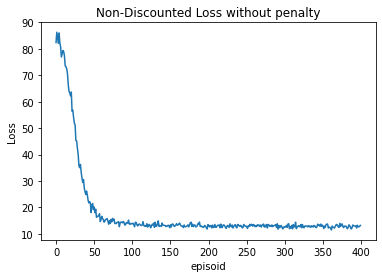

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

Text(0.5, 1.0, 'Test loss for RNN with Lyapunov')

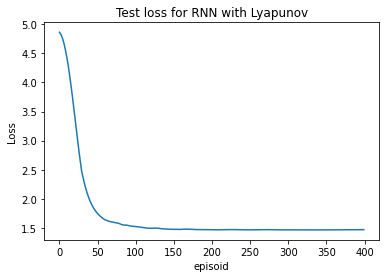

In [ ]:
plt.plot(loss_RNN_test_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Test loss for RNN with Lyapunov')

In [32]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_linear(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,exp_alpha,linear_coff,**kwargs):
        self.units = units
        self.action_units=action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.exp_alpha=exp_alpha#exp_stable_threshold
        self.delta_t=tf.constant(env.delta_t,dtype=tf.float32)
        self.linear_coff=tf.constant(linear_coff.T,dtype=tf.float32)
        self.state_transfer1=tf.constant(env.state_transfer1,dtype=tf.float32)
        self.state_transferF=tf.constant(env.state_transferF,dtype=tf.float32)
        self.state_transferG=tf.constant(env.state_transferG,dtype=tf.float32)
        self.state_transfer2=tf.constant(env.state_transfer2,dtype=tf.float32)
        self.state_transfer3=tf.constant(env.state_transfer3,dtype=tf.float32)
        self.state_transfer4=tf.constant(env.state_transfer4,dtype=tf.float32)
        self.select_add_w=tf.constant(env.select_add_w,dtype=tf.float32)
        self.select_w=tf.constant(env.select_w,dtype=tf.float32)
        self.select_delta=tf.constant(env.select_delta,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.Multiply_ones=tf.tile(tf.ones((action_units,action_units),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.w_recover=tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype=tf.float32)
        self.b_recover=tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype=tf.float32)
        self.ones_frequency=tf.ones((action_units,internal_units),dtype=tf.float32)
        self.Multiply_ones_diag=tf.tile(tf.eye(action_units,dtype=tf.float32)[None], [batchsize, 1, 1]) 
        self.minus_ref_one=tf.constant(env.minus_ref_one,dtype=tf.float32)
        
        self.state_transfer1_continuous=tf.constant(env.state_transfer1_continuous,dtype=tf.float32)
        self.state_transferF_continuous=tf.constant(env.state_transferF_continuous,dtype=tf.float32)
        self.state_transferG_continuous=tf.constant(env.state_transferG_continuous,dtype=tf.float32)
        self.state_transfer3_continuous=tf.constant(env.state_transfer3_continuous,dtype=tf.float32)
        self.state_transfer4_continuous=tf.constant(env.state_transfer4_continuous,dtype=tf.float32)
        self.minus_ref_one_recover_u=tf.constant(env.minus_ref_one_recover_u,dtype=tf.float32)

        super(MinimalRNNCell_linear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_plus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp')
        self.w_minus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp')
        self.built = True

    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_output = states[0]

        action_nonconstrain=K.sum(tf.linalg.diag(K.dot(prev_output,TrainData.select_w))*self.linear_coff,axis=2)

        action=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)

        
        # integrate the state transition dynamics
        new_state=K.dot(prev_output, self.state_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=np.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF,axis=2 )\
                  +K.sum((K.cos( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=tf.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                          -self.Multiply_ones_diag)\
                        *self.state_transferG,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3+K.dot(action,self.state_transfer4)

        loss0 = K.dot(K.pow(new_state,2),self.select_add_w)
        frequency=K.dot(new_state,self.select_w)

        
        return [loss0,frequency,action], [new_state]
    





In [ ]:

cell_linear = MinimalRNNCell_linear(units,action_units,internal_units_RNN,env,Batch_num_RNN,exp_alpha,linear_coff)

layer_linear = RNN(cell_linear,return_sequences=True,stateful = True)
input_1_linear = tf.keras.Input(batch_shape=(Batch_num_RNN,T,units))
outputs_linear = layer_linear((input_1_linear))
model_linear = tf.keras.models.Model([input_1_linear], outputs_linear)
model_linear.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

x0_linear=np.ones((Batch_num_RNN,T,units))
y0_linear=model_linear(x0_linear)
layer_linear.reset_states(batch_test_initial)
[loss0,frequency,action]=model_linear(x0_linear)
loss_linear_test=(K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2)))/Batch_num_RNN
loss_linear_test

# RNN Simulate

In [ ]:
def Action(state,model,env):
    
    w_plus=K.dot(tf.math.square(model.variables[0]),cell.w_recover)
    b_plus=K.dot(-tf.math.square(model.variables[1]),cell.b_recover)
    w_minus=K.dot(-tf.math.square(model.variables[2]),cell.w_recover)
    b_minus=K.dot(-tf.math.square(model.variables[3]),cell.b_recover)
    nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_plus)\
                    *w_plus,axis=2)  
    nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_minus)\
                    *w_minus,axis=2)  
    action_nonconstrain= nonlinear_plus+nonlinear_minus
    action_init=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
      
    return action_init


[[ 9.1133572e-02  5.5222386e-01  1.0000000e+00  4.0786996e-01
   6.1828053e-01  4.4674450e-01  4.5903459e-01  4.0887848e-01
   6.3822925e-01 -4.4816729e-02 -4.2042561e-09  5.7612905e-08
   5.0000000e-01 -2.2351742e-08  2.3165575e-07 -9.5316047e-08
   2.2351742e-08 -4.7830888e-08  1.1007423e-07 -1.2233481e-08]]
[[8.996717]]


Text(0, 0.5, 'w (p.u.)')

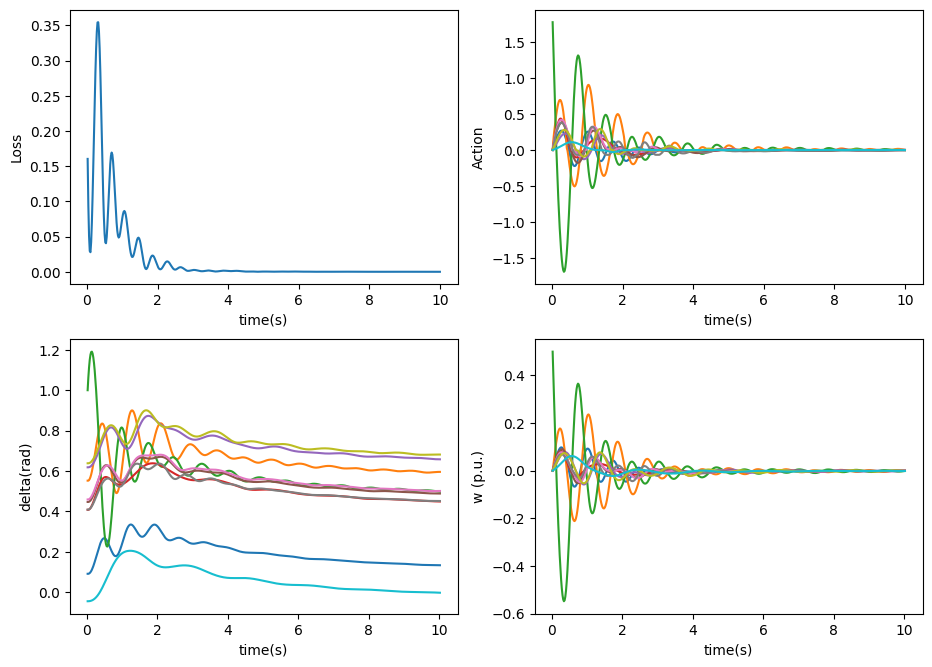

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

gen_idx=2
init_state=equilibrium_init.reshape((1,-1)).copy()

init_state[0,gen_idx]=1
init_state[0,gen_idx+action_units]=0.5
print(init_state)

s=init_state
env.set_state(s)
Trajectory_RNN.append(s)
SimulationLength=500
Record_u=[]
Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
for i in range(SimulationLength):
    u=np.squeeze(Action(s,layer,env))
    next_s, r= env.step(u)
    Loss_RNN_discounted+=r
    Loss_RNN+=r
    s=next_s
    Trajectory_RNN.append(s)
    Record_u.append(u)
    Record_Loss.append(np.squeeze(r))

print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

[[ 4.02310491e-02  6.54643118e-01  1.00000000e+00  4.37460482e-01
   6.91510260e-01  4.61602747e-01  4.09979314e-01  4.03639674e-01
   7.35993445e-01 -1.39941990e-01 -1.07678774e-04 -1.07540211e-04
   5.00000000e-01 -1.07605767e-04 -1.07669141e-04 -1.07667569e-04
  -1.07667664e-04 -1.07688487e-04 -1.07659987e-04 -1.07664113e-04]]


Text(0, 0.5, 'w (p.u.)')

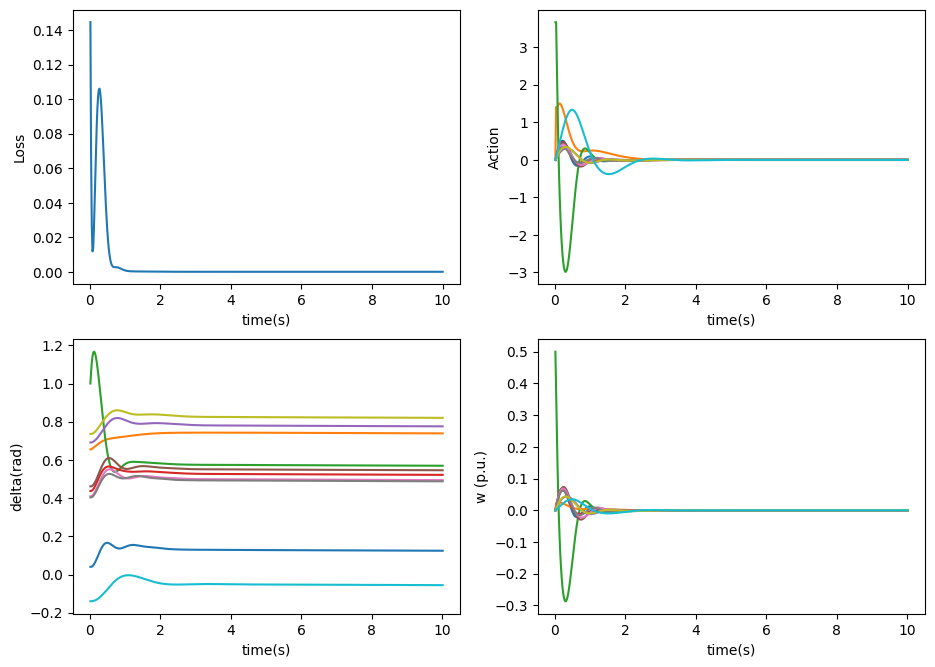

In [ ]:
# Compare the trajectory for linear
Trajectory_Linear=[]  
s=init_state.copy()
print(init_state)        

env.set_state(s)
Trajectory_Linear.append(s)
# SimulationLength=500
Record_u_Linear=[]
Record_Loss_Linear=[]
Loss_Linear=0
for i in range(SimulationLength):
    u=np.squeeze(Action_linear(s,linear_coff,env))
    next_s, r= env.step(u)
    Loss_Linear+=r
    s=next_s
    Trajectory_Linear.append(s)
    Record_u_Linear.append(u)
    Record_Loss_Linear.append(np.squeeze(r))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss_Linear)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')
plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_Linear[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_Linear[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

# Plot action

In [ ]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

initial_state1=np.random.uniform(0.0,0.3,(1,action_units))
initial_state2=np.random.uniform(-0.03,0.03,(1,action_units))
s_concate0=np.hstack((initial_state1,initial_state2)).astype(np.float32)
s_concate0=equilibrium_init.reshape((1,-1)).copy()
state_d=np.float32(0.2)

state_w=np.arange(-1,1,0.02,dtype=np.float32)
state_d2=np.float32(0.03)
state_w2=np.float32(0.02)

action_dw=np.zeros(len(state_w))
action_dw_linear=np.zeros(len(state_w))

fig=plt.figure(figsize=(15,10), dpi=100)
plt.subplot(2,2,1)
for idx_plot in range(action_units):
    gen_idx=idx_plot
    s_concate=copy.deepcopy(s_concate0)
    for j in range(len(state_w)):
            s_concate[0,action_units+gen_idx]=state_w[j]
            u=Action(s_concate,layer,env)
            u_linear=Action_linear(s_concate,linear_coff,env)
            action_dw[j]=u[0][gen_idx]
            action_dw_linear[j]=u_linear[0][gen_idx]
    plt.subplot(np.ceil(action_units/3),3,idx_plot+1)
    plt.plot(state_w,action_dw, label='RNN')
    plt.plot(state_w,action_dw_linear, label='Linear')
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('w (p.u.)')
    plt.ylabel('Action(p.u.)') 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()    
